In [ ]:
!pip install -q kaggle


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covid19-image-dataset' dataset.
Path to dataset files: /kaggle/input/covid19-image-dataset


In [ ]:
import os

base_dir = path

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        n_files = len(os.listdir(cls_path))
        print(f"{cls:15s} -> {n_files} images")

Covid19-dataset -> 2 images


In [ ]:
import glob
import numpy as np # Import numpy
import cv2 # Import opencv
import os # Ensure os is imported for path manipulation

image_size = (224, 224)

# Adjust path to use the downloaded dataset base path
# Assuming 'path' variable from kagglehub.dataset_download is available
# and it points to '/kaggle/input/covid19-image-dataset'
base_dir = os.path.join(path, "Covid19-dataset", "train")

classes = ["Covid", "Normal", "Viral Pneumonia"]  # check from folder names
images = []
labels = []

for cls in classes:
    cls_folder = os.path.join(base_dir, cls)
    if not os.path.exists(cls_folder):
        print(f"Warning: Class folder not found: {cls_folder}. Skipping.")
        continue
    for img_path in glob.glob(os.path.join(cls_folder, "*")):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image: {img_path}. Skipping.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        images.append(img)
        labels.append(cls)

X = np.array(images, dtype="float32")
y = np.array(labels)

print("X shape:", X.shape)
print("y shape:", y.shape)
unique, counts = np.unique(y, return_counts=True)
print("Class counts:")
for u, c in zip(unique, counts):
    print(f"  {u}: {c}")


X shape: (251, 224, 224, 3)
y shape: (251,)
Class counts:
  Covid: 111
  Normal: 70
  Viral Pneumonia: 70


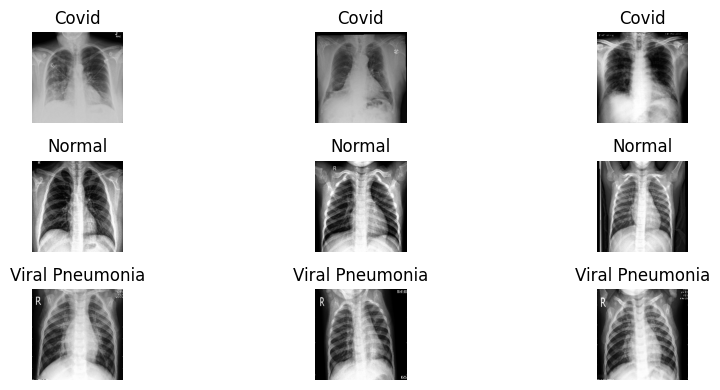

In [ ]:
import matplotlib.pyplot as plt

# 1.2: Show some sample images from each class
def show_samples_per_class(X, y, classes, n=3):
    plt.figure(figsize=(10, 4))
    idx = 1
    for cls in classes:
        cls_indices = np.where(y == cls)[0]
        sample_indices = np.random.choice(cls_indices, size=min(n, len(cls_indices)), replace=False)
        for i in sample_indices:
            plt.subplot(len(classes), n, idx)
            plt.imshow(X[i].astype("uint8"))
            plt.title(cls)
            plt.axis("off")
            idx += 1
    plt.tight_layout()
    plt.show()

show_samples_per_class(X, y, classes)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 2.1: Normalize
X_norm = X / 255.0

# 2.2: Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 0,1,2
num_classes = len(label_encoder.classes_)
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label mapping: {np.str_('Covid'): np.int64(0), np.str_('Normal'): np.int64(1), np.str_('Viral Pneumonia'): np.int64(2)}


In [ ]:
from sklearn.model_selection import train_test_split

# 2.3: Train/Validation/Test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_norm, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp
)  # 0.1111 of 90% ≈ 10%

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (200, 224, 224, 3) (200,)
Val shape: (25, 224, 224, 3) (25,)
Test shape: (26, 224, 224, 3) (26,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# 2.4: One-hot encode labels for CNNs
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

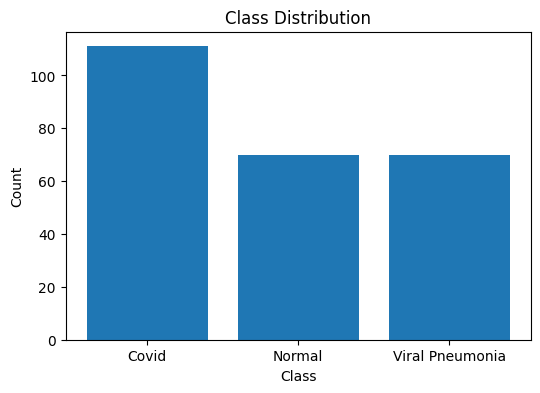

{np.str_('Covid'): np.int64(111),
 np.str_('Normal'): np.int64(70),
 np.str_('Viral Pneumonia'): np.int64(70)}

In [ ]:
# 3.1: Class distribution
unique, counts = np.unique(y_encoded, return_counts=True)
class_counts = dict(zip(label_encoder.inverse_transform(unique), counts))

plt.figure(figsize=(6,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

class_counts


In [ ]:
from tensorflow.keras import models, layers

input_shape = X_train.shape[1:]

def build_basic_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

basic_cnn = build_basic_cnn(input_shape, num_classes)
basic_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 4.1.2: Train basic CNN
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_basic = basic_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3262 - loss: 7.3232 - val_accuracy: 0.6400 - val_loss: 0.7882
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7484 - loss: 0.7179 - val_accuracy: 0.8000 - val_loss: 0.5732
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8710 - loss: 0.4289 - val_accuracy: 0.9200 - val_loss: 0.1879
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9456 - loss: 0.1510 - val_accuracy: 0.9200 - val_loss: 0.2241
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9525 - loss: 0.1159 - val_accuracy: 0.8800 - val_loss: 0.2679
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9854 - loss: 0.0823 - val_accuracy: 0.9200 - val_loss: 0.1503
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9734 - loss: 0.0573 - val_accuracy: 0.9200 - val_loss: 0.1124
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.9600 - val_loss: 0.1028
Epoch 9/

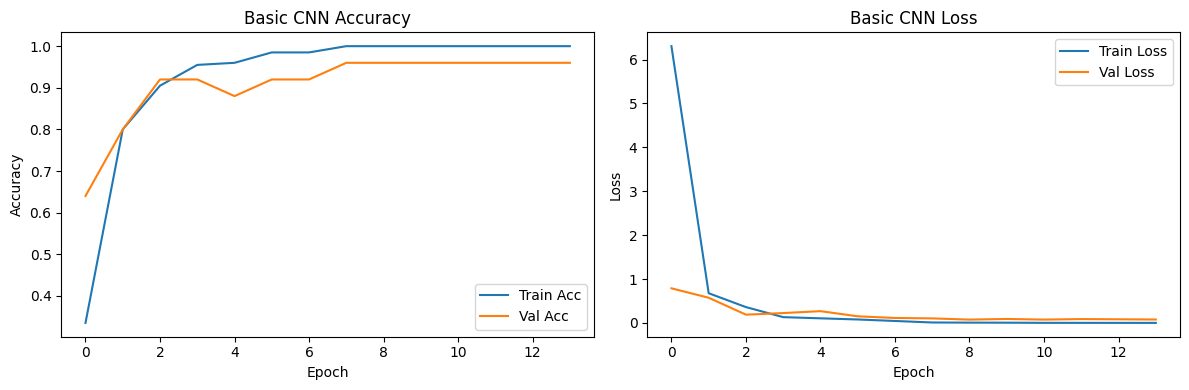

In [ ]:
# 4.1.3: Plot accuracy & loss
def plot_history(history, title_prefix=""):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title_prefix + " Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title_prefix + " Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_basic, "Basic CNN")


In [ ]:
def build_deep_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

deep_cnn = build_deep_cnn(input_shape, num_classes)
deep_cnn.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,830,563 (98.54 MB)

 Trainable params: 25,830,563 (98.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - accuracy: 0.8735 - loss: 0.3448 - val_accuracy: 0.8800 - val_loss: 0.4540
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 9s/step - accuracy: 0.8721 - loss: 0.3594 - val_accuracy: 0.8800 - val_loss: 0.3826
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - accuracy: 0.8998 - loss: 0.3164 - val_accuracy: 0.9200 - val_loss: 0.5616
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 9s/step - accuracy: 0.9327 - loss: 0.2305 - val_accuracy: 0.9200 - val_loss: 0.2295
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - accuracy: 0.9007 - loss: 0.2420 - val_accuracy: 0.9200 - val_loss: 0.4380
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 9s/step - accuracy: 0.9293 - loss: 0.2287 - val_accuracy: 0.9200 - val_loss: 0.2100
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - accuracy: 0.8975 - loss: 0.2329 - val_accuracy: 0.9200 - val_loss: 0.3013
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - accuracy: 0.9158 - loss: 0.2191 - val_accuracy: 0.9600 - val_loss: 0.2281
Epoch 9/

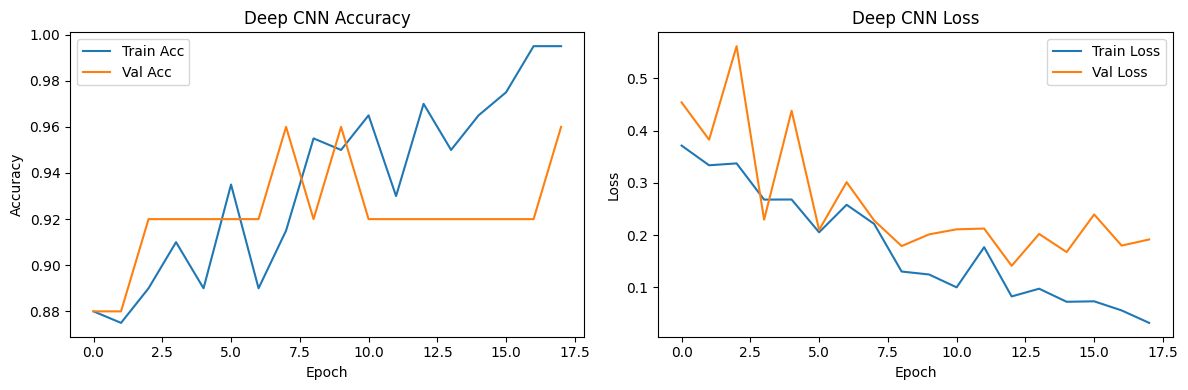

In [ ]:
history_deep = deep_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_deep, "Deep CNN")


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
import tensorflow as tf

# 4.3.1: Preprocess train/val/test using VGG16 preprocess (optional but recommended)
X_train_vgg = vgg_preprocess(X_train * 255.0)
X_val_vgg   = vgg_preprocess(X_val * 255.0)
X_test_vgg  = vgg_preprocess(X_test * 255.0)

def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # freeze base

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

vgg_model = build_vgg16_model(input_shape, num_classes)
vgg_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 20s/step - accuracy: 0.5439 - loss: 9.4471 - val_accuracy: 0.8400 - val_loss: 1.4729
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 140s 20s/step - accuracy: 0.9424 - loss: 0.5567 - val_accuracy: 0.9600 - val_loss: 0.6311
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 145s 21s/step - accuracy: 0.9626 - loss: 0.4787 - val_accuracy: 0.9600 - val_loss: 0.7998
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 198s 20s/step - accuracy: 0.9733 - loss: 0.4774 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 140s 20s/step - accuracy: 0.9881 - loss: 0.1347 - val_accuracy: 0.9600 - val_loss: 0.0858
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 140s 20s/step - accuracy: 0.9892 - loss: 0.2264 - val_accuracy: 1.0000 - val_loss: 8.9168e-07
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 147s 21s/step - accuracy: 0.9901 - loss: 0.1176 - val_accuracy: 1.0000 - val_loss: 8.5774e-06
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 140s 20s/step - accuracy: 0.9942 - loss: 0.0809 - val_accuracy: 0.9600 - v

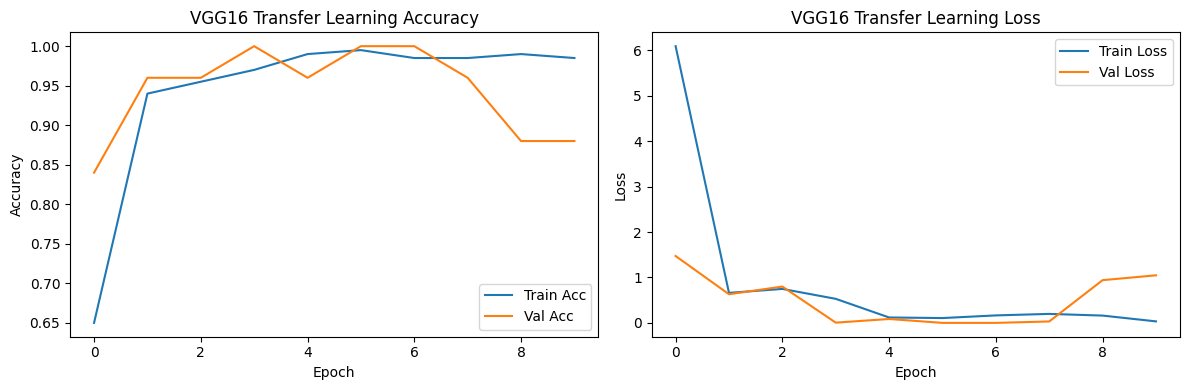

In [ ]:
history_vgg = vgg_model.fit(
    X_train_vgg, y_train_cat,
    validation_data=(X_val_vgg, y_val_cat),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_vgg, "VGG16 Transfer Learning")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# 4.4.1: Keras ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=resnet_preprocess
)

val_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

batch_size = 32

train_gen = train_datagen.flow(
    X_train * 255.0, y_train_cat,
    batch_size=batch_size,
    shuffle=True
)
val_gen = val_datagen.flow(
    X_val * 255.0, y_val_cat,
    batch_size=batch_size,
    shuffle=False
)
test_gen = val_datagen.flow(
    X_test * 255.0, y_test_cat,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
from tensorflow.keras.applications import ResNet50

def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # first stage: frozen

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

resnet_model = build_resnet50_model(input_shape, num_classes)
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3138 - loss: 2.3471

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.3120 - loss: 2.3221 - val_accuracy: 0.3200 - val_loss: 1.2385
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.4765 - loss: 1.2599 - val_accuracy: 0.7200 - val_loss: 0.6865
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.5617 - loss: 0.9475 - val_accuracy: 0.9600 - val_loss: 0.4065
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.7114 - loss: 0.7241 - val_accuracy: 0.9600 - val_loss: 0.2945
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.7146 - loss: 0.7111 - val_accuracy: 0.9600 - val_loss: 0.2224
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.7534 - loss: 0.5495 - val_accuracy: 0.9600 - val_loss: 0.2006
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8205 - loss: 0.4556 - val_accuracy: 0.9600 - val_loss: 0.1794
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8510 - loss: 0.3985 - val_accuracy: 0.9600 - val_loss: 0.1556
Epoch 9/10
7/7 ━━━━

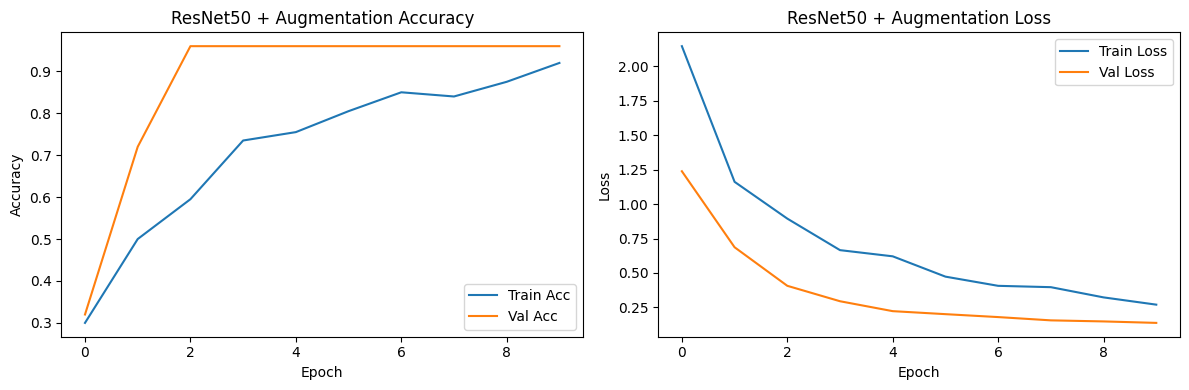

In [ ]:
history_resnet = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_resnet, "ResNet50 + Augmentation")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt # Import for plotting
import numpy as np # Import numpy

def evaluate_model(model, X_test_in, y_test_cat, model_name="Model"):
    # Predict
    y_pred_prob = model.predict(X_test_in)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Accuracy
    acc = np.mean(y_pred == y_true)
    print(f"{model_name} Test Accuracy: {acc:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm, "\n")

    # Classification report
    target_names = label_encoder.classes_
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # ROC-AUC for multi-class (one-vs-rest)
    y_bin = label_binarize(y_true, classes=range(num_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(6,5))
    colors = cycle(['b', 'g', 'r'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0,1],[0,1],'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} ROC Curves (macro AUC = {roc_auc['macro']:.2f})")
    plt.legend(loc="lower right")
    plt.show()

    return acc, roc_auc["macro"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Basic CNN Test Accuracy: 0.9615

Confusion Matrix:
[[12  0  0]
 [ 0  6  1]
 [ 0  0  7]] 

Classification Report:
                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        12
         Normal       1.00      0.86      0.92         7
Viral Pneumonia       0.88      1.00      0.93         7

       accuracy                           0.96        26
      macro avg       0.96      0.95      0.95        26
   weighted avg       0.97      0.96      0.96        26



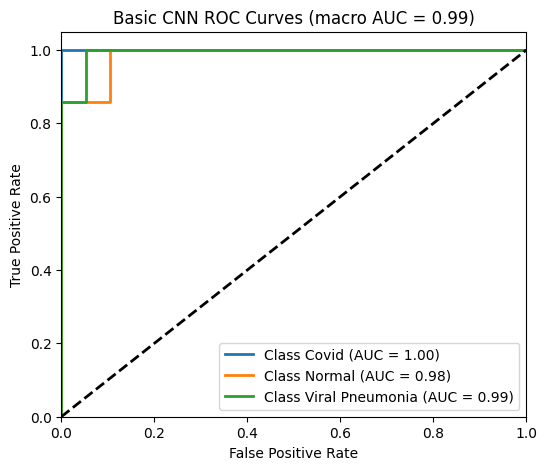

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Deep CNN Test Accuracy: 0.9231

Confusion Matrix:
[[12  0  0]
 [ 1  6  0]
 [ 1  0  6]] 

Classification Report:
                 precision    recall  f1-score   support

          Covid       0.86      1.00      0.92        12
         Normal       1.00      0.86      0.92         7
Viral Pneumonia       1.00      0.86      0.92         7

       accuracy                           0.92        26
      macro avg       0.95      0.90      0.92        26
   weighted avg       0.93      0.92      0.92        26



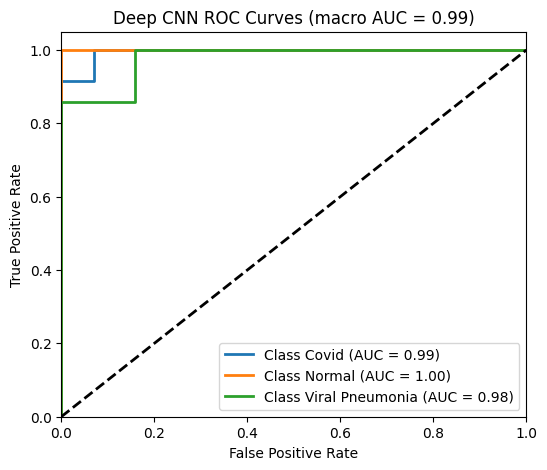

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
VGG16 Test Accuracy: 0.9615

Confusion Matrix:
[[12  0  0]
 [ 0  6  1]
 [ 0  0  7]] 

Classification Report:
                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        12
         Normal       1.00      0.86      0.92         7
Viral Pneumonia       0.88      1.00      0.93         7

       accuracy                           0.96        26
      macro avg       0.96      0.95      0.95        26
   weighted avg       0.97      0.96      0.96        26



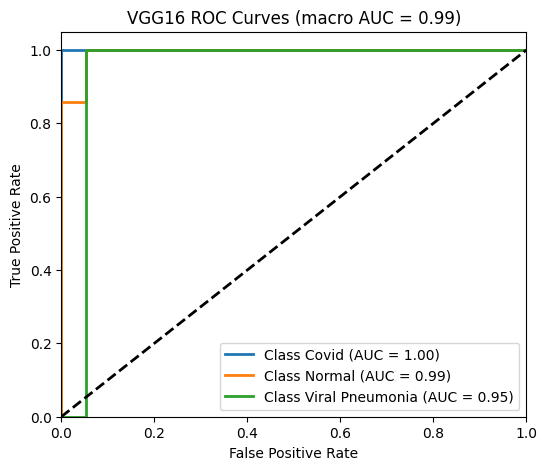

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
ResNet50 Test Accuracy: 0.8846153846153846


In [ ]:
# For basic and deep CNN we used X_test_norm
basic_acc, basic_auc = evaluate_model(basic_cnn, X_test, y_test_cat, "Basic CNN")
deep_acc, deep_auc   = evaluate_model(deep_cnn, X_test, y_test_cat, "Deep CNN")

# For VGG we used VGG preprocessing
vgg_acc, vgg_auc     = evaluate_model(vgg_model, X_test_vgg, y_test_cat, "VGG16")

# For ResNet we used generator
y_test_prob_resnet = resnet_model.predict(test_gen)
y_test_pred_resnet = np.argmax(y_test_prob_resnet, axis=1)
y_test_true_resnet = np.argmax(y_test_cat, axis=1)

print("ResNet50 Test Accuracy:", np.mean(y_test_pred_resnet == y_test_true_resnet))
# You can adapt evaluate_model for generator similarly, or reuse its logic


In [ ]:
# 6.1: Visual already done; here compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights_dict)
print("Label mapping:", dict(zip(range(num_classes), label_encoder.classes_)))


Class weights: {0: np.float64(0.7575757575757576), 1: np.float64(1.1904761904761905), 2: np.float64(1.1904761904761905)}
Label mapping: {0: np.str_('Covid'), 1: np.str_('Normal'), 2: np.str_('Viral Pneumonia')}


In [ ]:
!pip install keras-tuner
import keras_tuner as kt

def model_builder(hp):
    hp_filters = hp.Choice('filters', values=[32, 64])
    hp_units = hp.Choice('dense_units', values=[128, 256])
    hp_dropout = hp.Choice('dropout', values=[0.3, 0.5])

    model = models.Sequential()
    model.add(layers.Conv2D(hp_filters, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(hp_filters*2, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp_units, activation='relu'))
    model.add(layers.Dropout(hp_dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=3,  # increase later if you want
    executions_per_trial=1,
    directory='kt_covid',
    project_name='basic_cnn_tuning'
)

tuner.search(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=5,
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print("Filters:", best_hps.get('filters'))
print("Dense units:", best_hps.get('dense_units'))
print("Dropout:", best_hps.get('dropout'))
print("Learning rate:", best_hps.get('learning_rate'))

Trial 3 Complete [00h 05m 52s]
val_accuracy: 0.9599999785423279

Best val_accuracy So Far: 0.9599999785423279
Total elapsed time: 00h 18m 08s
Best hyperparameters:
Filters: 64
Dense units: 128
Dropout: 0.3
Learning rate: 0.0001


In [ ]:
from sklearn.metrics import f1_score
import pandas as pd # Import pandas

def get_f1(model, X_test_in, y_test):
    y_pred_prob = model.predict(X_test_in)
    y_pred = np.argmax(y_pred_prob, axis=1)
    return f1_score(y_test, y_pred, average='macro')

def train_accuracy(model, X_train_in, y_train):
    y_pred = np.argmax(model.predict(X_train_in), axis=1)
    return np.mean(y_pred == y_train)

# Basic CNN
basic_train_acc = train_accuracy(basic_cnn, X_train, y_train)
basic_test_acc  = np.mean(np.argmax(basic_cnn.predict(X_test), axis=1) == y_test)
basic_f1        = get_f1(basic_cnn, X_test, y_test)

# Deep CNN
deep_train_acc = train_accuracy(deep_cnn, X_train, y_train)
deep_test_acc  = np.mean(np.argmax(deep_cnn.predict(X_test), axis=1) == y_test)
deep_f1        = get_f1(deep_cnn, X_test, y_test)

# VGG16
vgg_train_acc = train_accuracy(vgg_model, X_train_vgg, y_train)
vgg_test_acc  = np.mean(np.argmax(vgg_model.predict(X_test_vgg), axis=1) == y_test)
vgg_f1        = get_f1(vgg_model, X_test_vgg, y_test)

# ResNet50
resnet_train_acc = train_accuracy(resnet_model, X_train * 255.0, y_train)  # using same preprocessing as generator
resnet_test_acc  = np.mean(y_test_pred_resnet == y_test_true_resnet)
resnet_f1        = f1_score(y_test_true_resnet, y_test_pred_resnet, average='macro')

def overfit_flag(train_acc, test_acc, threshold=0.1):
    return "Y" if (train_acc - test_acc) > threshold else "N"

comparison = pd.DataFrame({
    "Model": ["CNN Basic", "Deep CNN", "VGG16", "ResNet50"],
    "Train Acc": [basic_train_acc, deep_train_acc, vgg_train_acc, resnet_train_acc],
    "Test Acc": [basic_test_acc, deep_test_acc, vgg_test_acc, resnet_test_acc],
    "F1 Score": [basic_f1, deep_f1, vgg_f1, resnet_f1],
    "Overfitting (Y/N)": [
        overfit_flag(basic_train_acc, basic_test_acc),
        overfit_flag(deep_train_acc, deep_test_acc),
        overfit_flag(vgg_train_acc, vgg_test_acc),
        overfit_flag(resnet_train_acc, resnet_test_acc),
    ]
})

comparison


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 120s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step


,Model,Train Acc,Test Acc,F1 Score,Overfitting (Y/N)
0,CNN Basic,1.000,0.961538,0.952137,N
1,Deep CNN,0.985,0.923077,0.923077,N
2,VGG16,1.000,0.961538,0.952137,N
3,ResNet50,0.845,0.884615,0.882222,N
